In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(842663, 112)


In [27]:

# Time to engagement
if nu.pickle_exists('time_to_engagement_df'):
    time_to_engagement_df = nu.load_object('time_to_engagement_df')
else:
    
    # Initialize an empty list to store rows of data
    rows_list = []
    group_actions_list = ['S_A_L_T_WALKED', 'S_A_L_T_WALK_IF_CAN', 'S_A_L_T_WAVE_IF_CAN', 'S_A_L_T_WAVED']
    gb = frvrs_logs_df.sort_values(['elapsed_time']).groupby(fu.scene_groupby_columns)
    
    # Loop through the grouped data (grouped by UUID and scene)
    for (session_uuid, scene_index), scene_df in gb:
        
        # Get the logger version for the file and scene categories
        logger_version = fu.get_logger_version(scene_df)
        is_scene_aborted = fu.get_is_scene_aborted(scene_df)
        scene_type = fu.get_scene_type(scene_df)
        
        # Create a boolean mask for the patient engaged action type
        action_mask_series = (scene_df.action_type == 'PATIENT_ENGAGED')
        
        # Check if there are any rows with the patient engaged action type
        if scene_df[action_mask_series].shape[0]:
            
            # Initialize a dictionary to store row data
            row_dict = {}
            
            # Store logger version, session uuid, scene index, and other scene categories
            for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
            row_dict['logger_version'] = logger_version
            row_dict['is_scene_aborted'] = is_scene_aborted
            row_dict['scene_type'] = scene_type
            scene_start = fu.get_scene_start(scene_df)
            row_dict['scene_start'] = scene_start
            
            # Calculate and add the time to last engagement
            last_engagement = fu.get_last_engagement(scene_df)
            row_dict['last_engagement'] = last_engagement
            
            # Create a mask for the row with the first engagement
            mask_series = action_mask_series & (scene_df.elapsed_time == last_engagement)
            
            # Get the patient ID of the last engagement and add it
            patient_id = scene_df[mask_series].patient_id.squeeze()
            row_dict['last_patient_id'] = patient_id

            # Expand the data frame to the patient's entire history
            patient_mask_series = True
            for cn in fu.scene_groupby_columns: patient_mask_series &= (frvrs_logs_df[cn] == eval(cn))
            patient_mask_series &= (frvrs_logs_df.patient_id == patient_id)
            
            # Create a mask for rows with the same patient id and initiated by responder
            mask_series = (frvrs_logs_df.action_type.isin(nu.responder_negotiations_list+group_actions_list) & patient_mask_series)
            
            # Calculate the time to the first notice and add it
            first_notice_to_last_patient = frvrs_logs_df[mask_series].elapsed_time.min()
            row_dict['first_notice_to_last_patient'] = first_notice_to_last_patient
            
            # Calculate the time to engagement by subtracting first notice from first engagement
            row_dict['start_to_last_engagement'] = last_engagement - scene_start
            row_dict['notice_to_last_engagement'] = last_engagement - first_notice_to_last_patient
            
            # Calculate and add the time to first engagement
            first_engagement = fu.get_first_engagement(scene_df)
            row_dict['first_engagement'] = first_engagement
            
            # Create a mask for the row with the first engagement
            mask_series = action_mask_series & (scene_df.elapsed_time == first_engagement)
            
            # Get the patient ID of the first engagement and add it
            patient_id = scene_df[mask_series].patient_id.squeeze()
            row_dict['first_patient_id'] = patient_id

            # Expand the data frame to the patient's entire history
            patient_mask_series = True
            for cn in fu.scene_groupby_columns: patient_mask_series &= (frvrs_logs_df[cn] == eval(cn))
            patient_mask_series &= (frvrs_logs_df.patient_id == patient_id)
            
            # Create a mask for rows with the same patient id and initiated by responder
            mask_series = (frvrs_logs_df.action_type.isin(nu.responder_negotiations_list+group_actions_list) & patient_mask_series)
            
            # Calculate the time to the first notice and add it
            first_notice_to_first_patient = frvrs_logs_df[mask_series].elapsed_time.min()
            row_dict['first_notice_to_first_patient'] = first_notice_to_first_patient
            
            # Calculate the time to engagement by subtracting first_notice from first_engagement
            row_dict.start_to_first_engagement = first_engagement - scene_start
            row_dict['notice_to_first_engagement'] = first_engagement - first_notice_to_first_patient
            
            # Append the row dictionary to the list of rows
            rows_list.append(row_dict)
    
    # Create a data frame from the list of row dictionaries
    time_to_engagement_df = DataFrame(rows_list)
    nu.store_objects(time_to_engagement_df=time_to_engagement_df)

In [20]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
columns_list = [
    'start_to_first_engagement', 'notice_to_first_engagement', 'start_to_last_engagement', 'notice_to_last_engagement'
]
df = time_to_engagement_df[mask_series][columns_list]
fu.show_time_statistics(df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
start_to_first_engagement,51,0,48,±26,0,37,48,1:01,4:13
notice_to_first_engagement,6,0,0,±12,0,0,0,9,1:44
start_to_last_engagement,6:38,8,6:54,±2:51,8,5:23,6:54,8:18,15:49
notice_to_last_engagement,5:22,0,5:45,±3:03,0,4:01,5:45,7:23,15:09



# Time to Last Engagement

In [13]:

columns_list = [
    'session_uuid', 'scene_index', 'is_scene_aborted', 'scene_type', 'scene_start', 'last_engagement', 'last_patient_id',
    'first_notice_to_last_patient', 'start_to_last_engagement', 'notice_to_last_engagement'
]
time_to_engagement_df.sort_values('start_to_last_engagement')[columns_list]

,session_uuid,scene_index,is_scene_aborted,scene_type,scene_start,last_engagement,last_patient_id,first_notice_to_last_patient,start_to_last_engagement,notice_to_last_engagement
672,ffecd29f-ebcd-45d2-9bc1-12adf56cfff8,4,False,Orientation,649281,655432,Mike_2 Root,655432,6151,0
457,aec5d448-c4e6-4af7-8e36-d258c7bb6f96,0,False,Triage,6698,14869,Gary_0 Root,14869,8171,0
238,5c720560-85f5-4bb1-9aa5-41207f6259a2,0,False,Triage,6402,18071,Gary_0 Root,18071,11669,0
45,0d3e0c62-db52-40f9-9ee8-7fc84a1dcbf2,0,False,Triage,3079,15723,Gary_0 Root,15723,12644,0
507,c82e4612-4e6f-4834-bc7f-6092327c44fa,0,False,Triage,10631,24319,Gary_0 Root,24319,13688,0
...,...,...,...,...,...,...,...,...,...,...
574,de04bec3-9503-467c-9c49-675720c4bab0,2,False,Triage,438332,1238723,Gloria_8 Root,477398,800391,761325
174,3cc73a53-22fd-4ce9-8696-6308f544dea2,0,False,Orientation,6275,814887,Mike_2 Root,295371,808612,519516
279,684d04c4-83c1-49b6-b798-ddd431438857,0,False,Triage,5550,843527,Lily_4 Root,48668,837977,794859
274,677d1c18-f292-4bcb-924d-52f5e762533f,1,False,Triage,432791,1366661,Gary_3 Root,456850,933870,909811


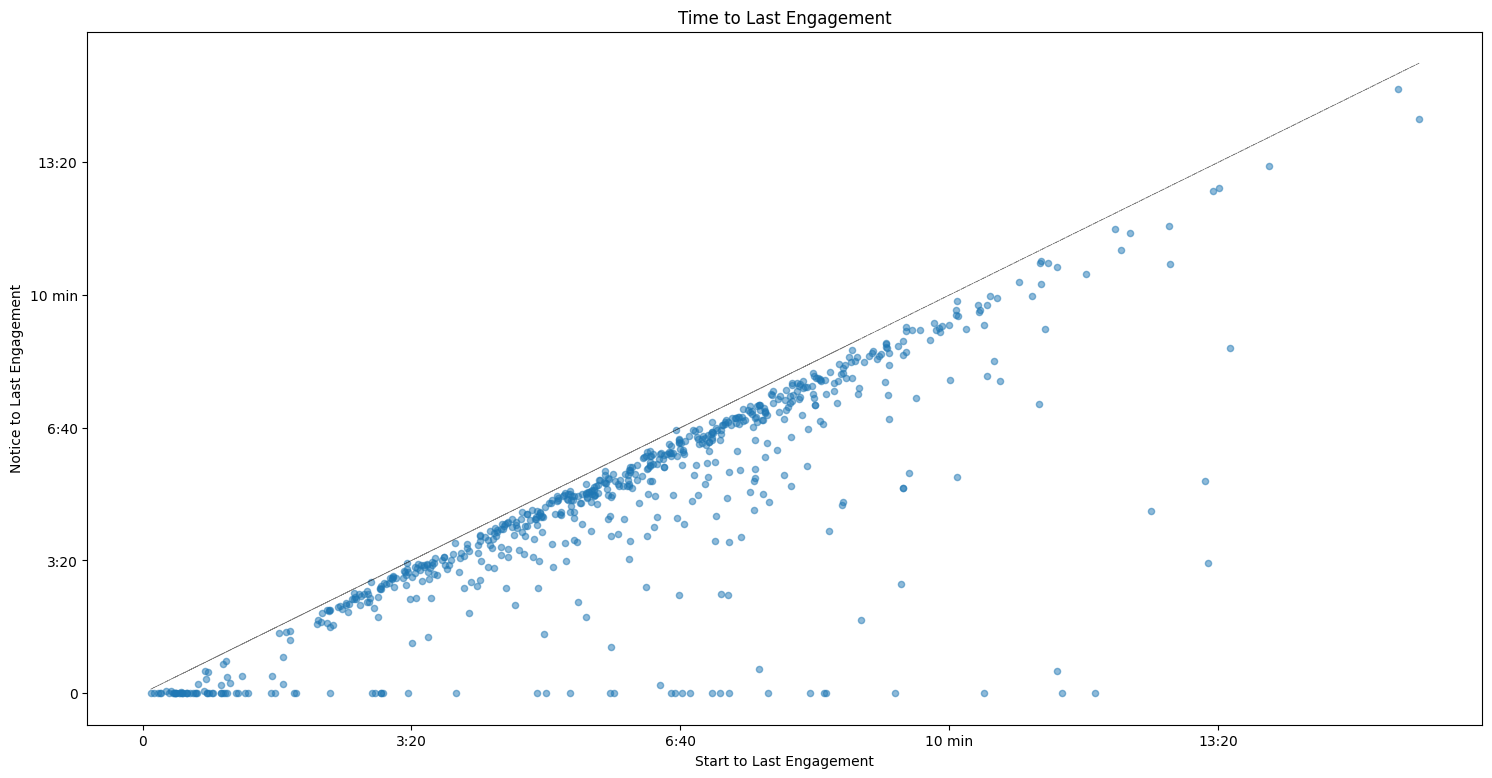

In [25]:

# Create a figure and add a subplot
fig, ax = plt.subplots(figsize=(18, 9))

# Plot the scatter plot
time_to_engagement_df.plot(x='start_to_last_engagement', y='notice_to_last_engagement', kind='scatter', ax=ax, alpha=0.5);

# Draw a diagonal line on the plot
ax.plot(time_to_engagement_df['start_to_last_engagement'], time_to_engagement_df['start_to_last_engagement'], color='black', linestyle='-.', linewidth=0.5, alpha=0.5);

# Set the title and labels
ax.set_title('Time to Last Engagement')
ax.set_xlabel('Start to Last Engagement')
ax.set_ylabel('Notice to Last Engagement')

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(fu.format_timedelta(timedelta(milliseconds=int(text_obj.get_position()[0]))))
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list)

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(fu.format_timedelta(timedelta(milliseconds=int(text_obj.get_position()[1]))))
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Show the plot
plt.show()

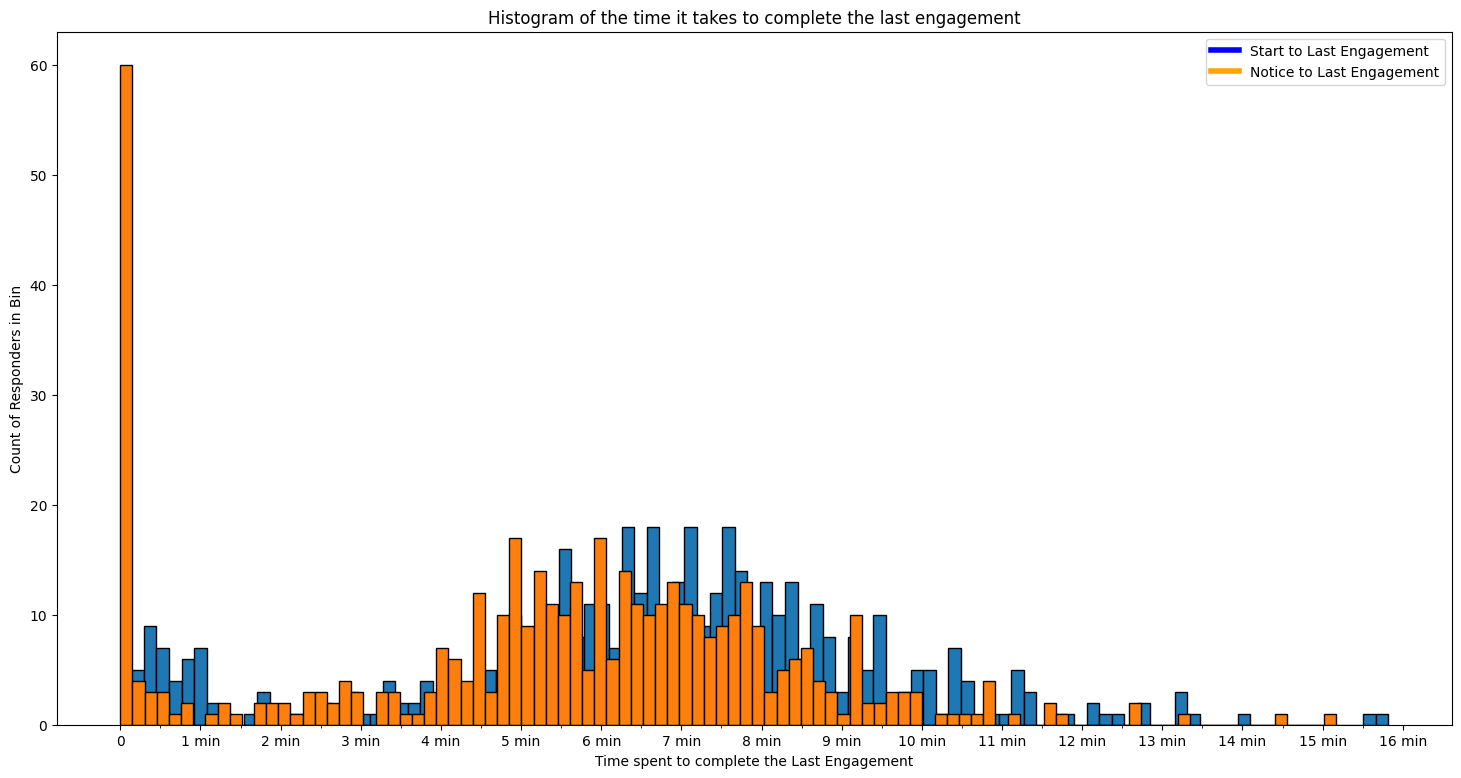

In [35]:

# Histogram of the time it takes to complete last engagement
xlabel = 'Time spent to complete the Last Engagement'

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: fu.format_timedelta(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

title = 'Histogram of the time it takes to complete the last engagement'
ylabel = 'Count of Responders in Bin'
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
ax = nu.plot_histogram(
    time_to_engagement_df[mask_series], 'start_to_last_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True
)
ax = nu.plot_histogram(
    time_to_engagement_df[mask_series], 'notice_to_last_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True,
    ax=ax
)

# Create the handles and labels for the legend
handles = [
    ax.plot([], [], color='blue', linewidth=4, label='Start to Last Engagement'),
    ax.plot([], [], color='orange', linewidth=4, label='Notice to Last Engagement'),
]
labels = ['Start to Last Engagement', 'Notice to Last Engagement']

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')

# Show the plot
plt.show()


# Time to First Engagement

In [16]:

columns_list = [
    'session_uuid', 'scene_index', 'is_scene_aborted', 'scene_type', 'scene_start', 'first_engagement', 'first_patient_id', 'first_notice_to_first_patient',
    'start_to_first_engagement', 'notice_to_first_engagement'
]
time_to_engagement_df.sort_values('start_to_first_engagement')[columns_list]

,session_uuid,scene_index,is_scene_aborted,scene_type,scene_start,first_engagement,first_patient_id,first_notice_to_first_patient,start_to_first_engagement,notice_to_first_engagement
271,6774cf2a-7728-4387-8788-934246a1e906,0,False,Orientation,6059,6059,Mike Root,6059,0,0
447,a9804531-1ed7-4b97-b3c1-96784faf5228,0,False,Triage,3346,3346,Mike Root,3346,0,0
635,f3228193-b6dc-41fa-a2ab-1c5085046347,1,False,Triage,287963,287963,Mike_2 Root,287963,0,0
544,d3ad6b20-821b-4821-a289-fe4eab2c940b,0,False,Triage,1754,1754,Mike Root,1754,0,0
312,724fdf45-3165-43b8-b9ca-dc07102d2886,12,False,Triage,5138713,5138713,Mike_2 Root,5138713,0,0
...,...,...,...,...,...,...,...,...,...,...
582,e072d31f-2592-4c7e-8709-3db1e111240c,0,False,Orientation,4596,206134,Mike_3 Root,191663,201538,14471
19,06574b6f-ab02-432c-9a65-7b031218a270,5,False,Orientation,1570369,1781935,Mike_3 Root,1781935,211566,0
606,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,0,False,Orientation,3753,219254,Mike_3 Root,219254,215501,0
388,8ec8afba-8533-4915-898f-5769c1258c61,0,False,Triage,9081,241847,Mike_3 Root,241847,232766,0


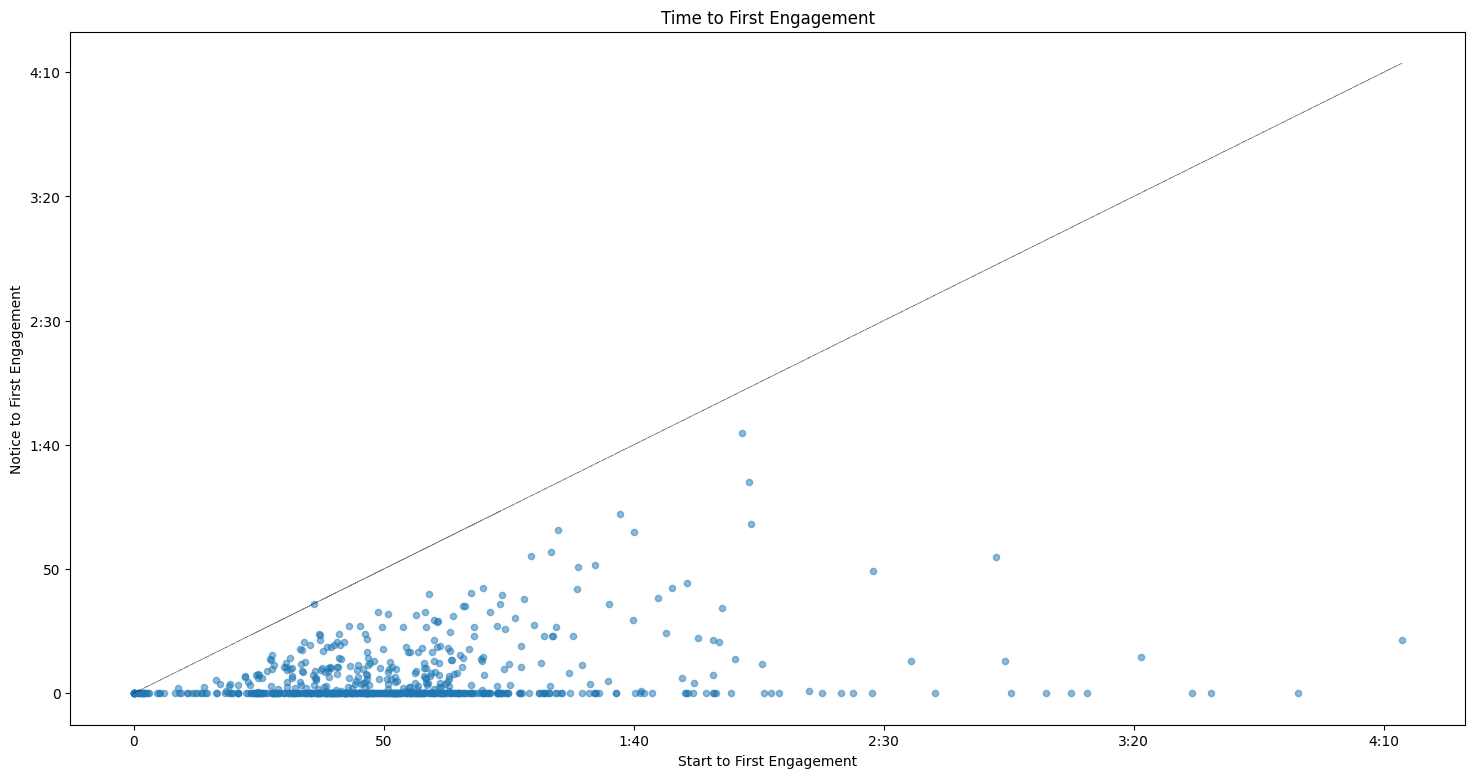

In [26]:

# Create a figure and add a subplot
fig, ax = plt.subplots(figsize=(18, 9))

# Plot the scatter plot
time_to_engagement_df.plot(x='start_to_first_engagement', y='notice_to_first_engagement', kind='scatter', ax=ax, alpha=0.5);

# Draw a diagonal line on the plot
ax.plot(time_to_engagement_df.start_to_first_engagement, time_to_engagement_df.start_to_first_engagement, color='black', linestyle='-.', linewidth=0.5, alpha=0.5);

# Set the title and labels
ax.set_title('Time to First Engagement')
ax.set_xlabel('Start to First Engagement')
ax.set_ylabel('Notice to First Engagement')

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(fu.format_timedelta(timedelta(milliseconds=int(text_obj.get_position()[0]))))
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list)

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(fu.format_timedelta(timedelta(milliseconds=int(text_obj.get_position()[1]))))
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Show the plot
plt.show()

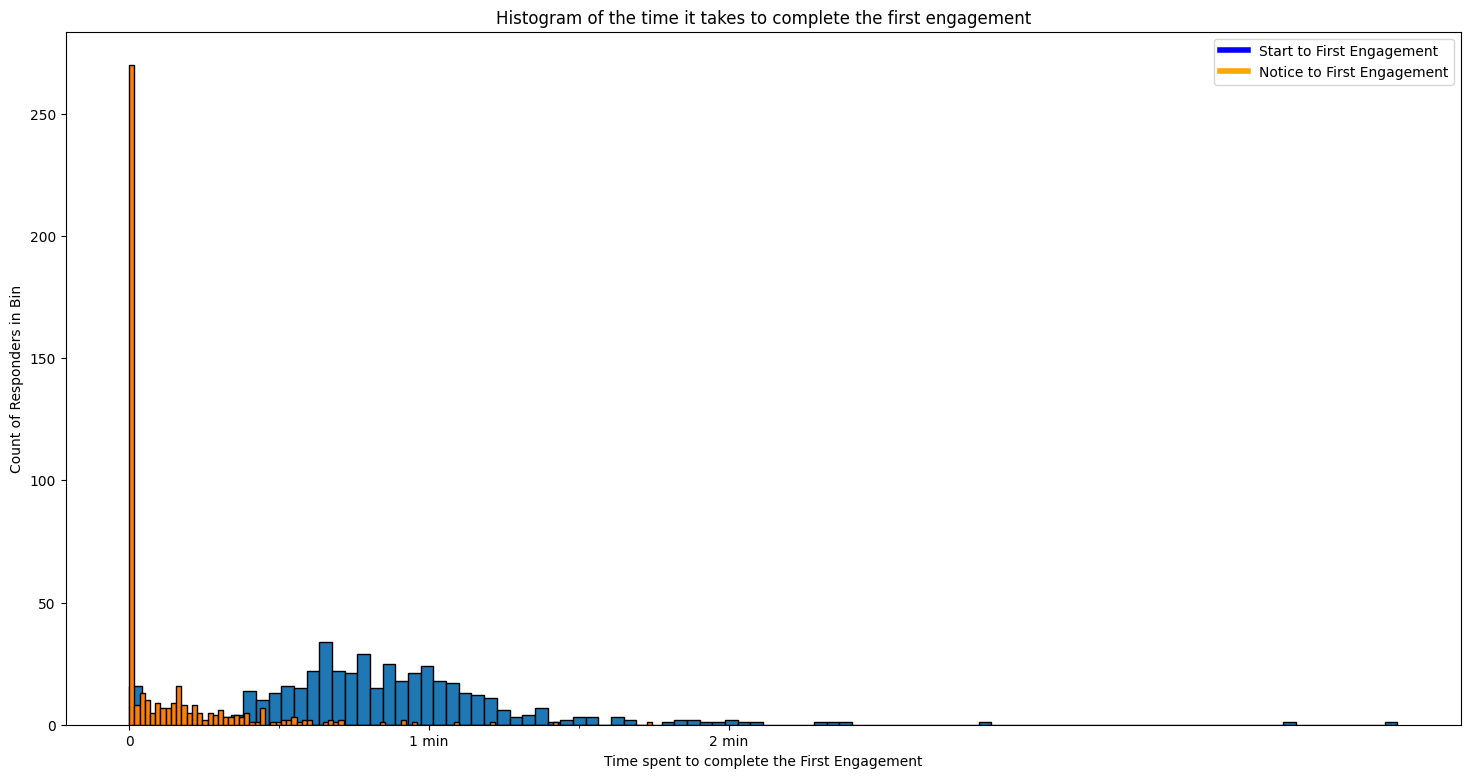

In [36]:

# Histogram of the time it takes to complete first engagement
xlabel = 'Time spent to complete the First Engagement'

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: fu.format_timedelta(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

title = 'Histogram of the time it takes to complete the first engagement'
ylabel = 'Count of Responders in Bin'
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
ax = nu.plot_histogram(
    time_to_engagement_df[mask_series], 'start_to_first_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True
)
ax = nu.plot_histogram(
    time_to_engagement_df[mask_series], 'notice_to_first_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True,
    ax=ax
)

# Create the handles and labels for the legend
handles = [
    ax.plot([], [], color='blue', linewidth=4, label='Start to First Engagement'),
    ax.plot([], [], color='orange', linewidth=4, label='Notice to First Engagement'),
]
labels = ['Start to Last Engagement', 'Notice to Last Engagement']

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')

# Show the plot
plt.show()


# Player Movements

In [ ]:

# Get scene with the fastest time to engagement, v1.3
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
mask_series &= (time_to_engagement_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    time_to_engagement_df, 'time_to_engagement', mask_series=mask_series, is_ascending=True, humanize_type='precisedelta',
    title_str='fastest time-to-engagement', frvrs_logs_df=None, verbose=False
)

In [ ]:

# Get scene with the fastest time to engagement, v1.0
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
mask_series &= (time_to_engagement_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    time_to_engagement_df, 'time_to_engagement', mask_series=mask_series, is_ascending=True, humanize_type='precisedelta',
    title_str='fastest time-to-engagement', frvrs_logs_df=None, verbose=False
)

In [ ]:

# Get scene with the slowest time to engagement, v1.3
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
mask_series &= (time_to_engagement_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    time_to_engagement_df, 'time_to_engagement', mask_series=mask_series, is_ascending=False, humanize_type='precisedelta',
    title_str='slowest time-to-engagement', frvrs_logs_df=None, verbose=False
)

In [ ]:

# Get scene with the slowest time to engagement, v1.0
mask_series = (time_to_engagement_df.scene_type == 'Triage') & (time_to_engagement_df.is_scene_aborted == False)
mask_series &= (time_to_engagement_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    time_to_engagement_df, 'time_to_engagement', mask_series=mask_series, is_ascending=False, humanize_type='precisedelta',
    title_str='slowest time-to-engagement', frvrs_logs_df=None, verbose=False
)